# Analyse SHAP values

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/myaReg-genderDifferences"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")
# 
import matplotlib.pyplot as plt 
from func_imputeScale import pipe_imputation_scaling, pipe_supervisedSelector
import shap
import pickle

from sklearn.pipeline import Pipeline

import matplotlib.colors

cmap_custom =  matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkgray","forestgreen"])

/home/WUR/katz001/miniconda3/envs/env_permit_gas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
translateVarsNames = {
    "gender":"gender",
    "age_erstmanifestation":"age at disease onset",
    "Diagnosedauer":"time to diagnosis ",
    "achrak_rb":"Anti-AChR ab",
    "antimuskak_rb":"Anti-MuSK ab",
    "pyridostigmin_sprb":"medication with pyridostigmine",
    "thymektomie_gr":"thymectomy",
    "immuntherapie_grrb":"therapy with immunosuppressants",
    "exazerbationstherapie_grrb":"excerbation therapy",
    "eskalationstherapiebeitherapierefraktaerermyasthenie_grrb":"escalation therapy",
    "autoimmunerkrankungen_rbzu":"autoimmune diseases (other)",
    "scoreadl_neu":"MG-ADL",
    "mgfaklassifikation_schlimmste_historisch_rb":"MGFA (worst)",
    "aktuelle_MGFA_umkodiert":"MGFA (current)",
    "muskelschmerz":"muscle pain",
    "zn_myasthener_exazerbation":"previous MG exacerbation",
    "chronicfatigue_neu":"chronic fatigue",
    "chronicfatigue_normalised":"chronic fatigue",    
    "seelischesbefinden_neu": "Anxiety and Depression",
    "generalisiertemuskelschwaeche": "generalisiertemuskelschwaeche"
}

In [3]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
n_iter = 300

dataset = "natural"
percentBoruta = 100
varFolder = "boruta"
vars = f"{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc"

''' 
Select features
'''
varPath = f"{PATH}/results/20_featureSelection/{dataset}/{varFolder}/{vars}.txt"
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()
with open(f"{PATH}/data/validation/discovery_validation_variables_translation.json", "r") as f: varTranslation = json.load(f)
variables_dutch = [varTranslation[ele] for ele in sel_variables]

''' 
Define paths
'''
resultsPath = f"{PATH}/results/40_externalValidation/{dataset}/"
folderFigures = f"{PATH}/figures/40_externalValidation/{dataset}/{vars}"
dataPath = f"{PATH}/data/validation/"

''' 
Read validation data
'''
with open(f"{PATH}/data/validation/validation_dtypes.json", "r") as f:
    dtypes = json.load(f)

data = pd.read_csv(f"{dataPath}/dutch_MG_patients_V2_recoded.csv", index_col=0, dtype=dtypes)
tmp = data.select_dtypes(include=["float32"]).columns 
data[tmp] = data[tmp].astype(pd.Int64Dtype())


X_val = data.drop(target, axis=1)
y_val = data[target]

print(X_val.shape)
print(y_val.value_counts())

(419, 39)
gender
1    222
0    197
Name: count, dtype: Int64


In [4]:
variables_dutch

['agefirstsymp', 'MGadl', 'HADS_comb', 'CISfatigue_minmax', 'AIDhistory']

In [5]:
''' Load SHAP'''
with open(f'{resultsPath}/bootstrap_validation_n{n_iter}_shap.pickle', 'rb') as f:
    dic_shap = pickle.load(f)
### sort
dic_shap = dict(sorted(dic_shap.items()))

average_shap_values = []
for k,v in dic_shap.items():
    average_shap_values.append(np.array(v).mean(axis=0)) 

In [6]:
''' 
Prepare dataframe for plotting
'''
num_columns = X_val.loc[:,variables_dutch].select_dtypes(include=["float64"]).columns
bin_columns = X_val.loc[:,variables_dutch].select_dtypes(include=["int64"]).columns
cat_columns = X_val.loc[:,variables_dutch].select_dtypes(include=["object"]).columns
preprocessor = pipe_imputation_scaling(num_columns, bin_columns, cat_columns)  


pipe = Pipeline([("selector", pipe_supervisedSelector(variables_dutch)),
                        ("imputation", preprocessor)])
X_imputed_plotting = pipe.fit_transform(X_val)
columnOrderAfterPreprocessing = [ele[5:] for ele in pipe["imputation"].get_feature_names_out()]
df_plotting = pd.DataFrame(X_imputed_plotting[list(dic_shap.keys())], columns=columnOrderAfterPreprocessing)

### INverse transform numerical variables to add to interpretability
num_inverseTransform = pipe[1].transformers_[0][1][1].inverse_transform(df_plotting.loc[:,pipe[1].transformers_[0][2].tolist()])
df_plotting.loc[:,pipe[1].transformers_[0][2].tolist()] = num_inverseTransform

## Manually binarise
bin_inverseTransform = df_plotting.loc[:,pipe[1].transformers_[1][2].tolist()]
bin_inverseTransform[bin_inverseTransform > 0.5] = 1
bin_inverseTransform[bin_inverseTransform < 0.5] = 0
df_plotting.loc[:,pipe[1].transformers_[1][2].tolist()] = bin_inverseTransform

# ##### Fix names
# df_plotting.columns = [translateVarsNames[ele] for ele in columnOrderAfterPreprocessing]
# df_plotting

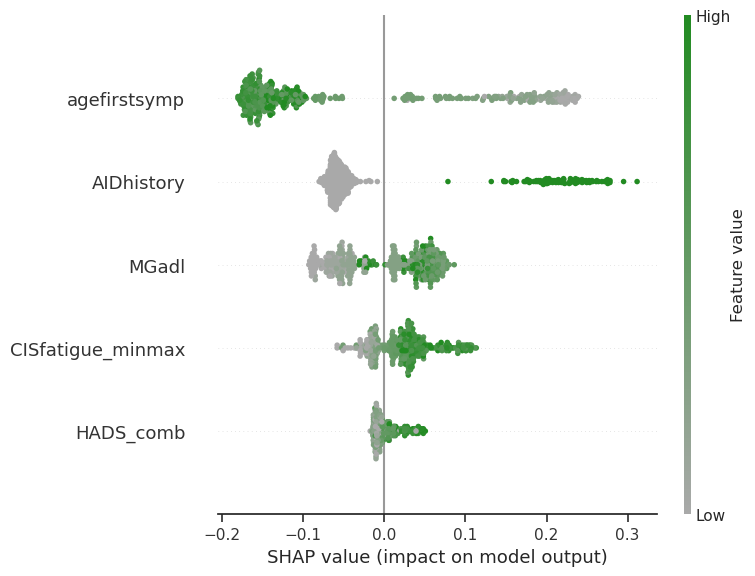

In [7]:
sns.set_theme(style="white", font_scale=1.2)
shap.summary_plot(np.array(average_shap_values), 
                  features=df_plotting,
                  cmap=cmap_custom,
                  show = False, sort=True, plot_size=(8.0,6.0))
# #plt.title(f'{datasetTimepoint}')
# plt.savefig(f"{folderFigures}/SHAP_n{n_iter}.png", dpi=300)
# plt.savefig(f"{folderFigures}/SHAP_n{n_iter}.pdf", dpi=300)

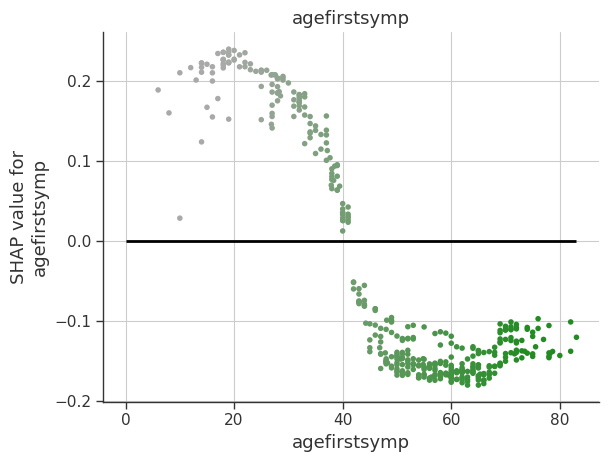

In [8]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")

for i,a in enumerate(df_plotting.loc[:,["agefirstsymp"]]):
    fig, ax = plt.subplots(1,1)
    ax.hlines(y=0, xmin=0, xmax=df_plotting.loc[:,a].max(), linestyles="-", colors='black', alpha=1, linewidth=2,zorder=1)
    shap.dependence_plot(a, np.array(average_shap_values), 
                        df_plotting, 
                        interaction_index=a,
                        cmap=cmap_custom,
                        ax=ax, title=a, show=False)
    # plt.tight_layout()
    # plt.savefig(f"{folderFigures}/SHAP_dependencePlot_{a}.png", dpi=300)
    # plt.savefig(f"{folderFigures}/SHAP_dependencePlot_{a}.pdf", dpi=300)